In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

In [3]:
from PIL import Image
from numpy import asarray

In [5]:
!pip install segmentation_models

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 3.1 MB/s eta 0:00:00


In [6]:
from tqdm import tqdm
from skimage.io import imread,imshow
from skimage.transform import resize
from zipfile import ZipFile
#from utils import create_train_val_datasets
#from DeeplabV3Plus import DeeplabV3Plus
import segmentation_models as sm
import seaborn as sns

Segmentation Models: using `tf.keras` framework.


In [7]:
from tensorflow import keras
from tensorflow.keras import layers
#from backbones import backbones_list as BACKBONES
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, UpSampling2D
from tensorflow.keras.applications import VGG19, ResNet50
# (
#     ResNet50, ResNet101, DenseNet121, DenseNet169, ResNet50V2, ResNet101V2,
#     EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3,
#     EfficientNetB4, EfficientNetB5, EfficientNetB6, EfficientNetB7,
#     EfficientNetV2B0,EfficientNetV2B1, EfficientNetV2B2, EfficientNetV2B3,
#     MobileNetV2, VGG16, VGG19, InceptionV3, ConvNeXtSmall, ConvNeXtTiny, ConvNeXtBase,
#     ConvNeXtLarge, NASNetLarge
# )

In [8]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, UpSampling2D
from tensorflow.keras.layers import AveragePooling2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model
# from tensorflow.keras.applications import (
#     ResNet50, ResNet101, DenseNet121, DenseNet169, ResNet50V2, ResNet101V2,
#     EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3,
#     EfficientNetB4, EfficientNetB5, EfficientNetB6, EfficientNetB7,
#     EfficientNetV2B0,EfficientNetV2B1, EfficientNetV2B2, EfficientNetV2B3, MobileNet,
#     MobileNetV2, VGG16, VGG19, InceptionV3, ConvNeXtSmall, ConvNeXtTiny, ConvNeXtBase,
#     ConvNeXtLarge, NASNetLarge
# )

# Experimental Backbones
# backbones_list = {
#     'resnet50': {'model': ResNet50, 'feature_1': 'conv4_block6_2_relu', 'feature_2': 'conv2_block3_2_relu'},
#     'resnet101': {'model': ResNet101,'feature_1': 'conv4_block19_2_relu', 'feature_2': 'conv2_block3_2_relu'},
#     'resnet50v2': {'model': ResNet50V2, 'feature_1': 'conv4_block4_1_relu', 'feature_2': 'conv2_block3_1_relu'},
#     'resnet101v2': {'model': ResNet101V2, 'feature_1': 'conv4_block23_1_relu', 'feature_2': 'conv2_block3_1_relu'},
#     'densenet121': {'model': DenseNet121, 'feature_1': 'relu', 'feature_2': 'conv2_block6_0_relu'},
#     'densenet169': {'model': DenseNet169, 'feature_1': 'relu','feature_2': 'conv3_block5_1_relu'},
#     'mobilenet': { 'model': MobileNet, 'feature_1': 'conv_pw_11_relu','feature_2': 'conv_pw_3_relu'},
#     'mobilenetv2': { 'model': MobileNetV2, 'feature_1': 'block_15_expand_relu','feature_2': 'block_2_expand_relu'},
#     'vgg16': { 'model': VGG16, 'feature_1': 'block5_conv3', 'feature_2': 'block3_conv3'},
#     'vgg19': { 'model': VGG19, 'feature_1': 'block5_conv4', 'feature_2': 'block3_conv4'}
# }
backbones_list = {
     'resnet50': {'model': ResNet50, 'feature_1': 'conv4_block6_2_relu', 'feature_2': 'conv2_block3_2_relu'},
#     'resnet101': {'model': ResNet101,'feature_1': 'conv4_block19_2_relu', 'feature_2': 'conv2_block3_2_relu'},
#     'resnet50v2': {'model': ResNet50V2, 'feature_1': 'conv4_block4_1_relu', 'feature_2': 'conv2_block3_1_relu'},
#     'resnet101v2': {'model': ResNet101V2, 'feature_1': 'conv4_block23_1_relu', 'feature_2': 'conv2_block3_1_relu'},
#     'densenet121': {'model': DenseNet121, 'feature_1': 'relu', 'feature_2': 'conv2_block6_0_relu'},
#     'densenet169': {'model': DenseNet169, 'feature_1': 'relu','feature_2': 'conv3_block5_1_relu'},
#     'mobilenet': { 'model': MobileNet, 'feature_1': 'conv_pw_11_relu','feature_2': 'conv_pw_3_relu'},
#     'mobilenetv2': { 'model': MobileNetV2, 'feature_1': 'block_15_expand_relu','feature_2': 'block_2_expand_relu'},
#     'vgg16': { 'model': VGG16, 'feature_1': 'block5_conv3', 'feature_2': 'block3_conv3'},
    'vgg19': { 'model': VGG19, 'feature_1': 'block5_conv4', 'feature_2': 'block3_conv4'}
}

In [9]:
BACKBONES = backbones_list

In [20]:
# Step 1: Load and preprocess the data
data_path = "/content/drive/MyDrive/Road_Anamoly_semantic_segmentation"
desired_width = 256
desired_height = 256

In [11]:
def load_and_preprocess_image(image_path):
    # Load the image using OpenCV
    image = cv2.imread(image_path)

    # Preprocess the image (e.g., resizing, normalization)
    image = cv2.resize(image, (desired_width, desired_height))
    image = image.astype(np.float32) / 255.0  # Normalize to [0, 1] range

    return image

In [12]:
def combine_masks(masks):
    # Combine the instance masks into a single mask
    combined_mask = np.zeros_like(masks[0], dtype=np.float32)
    for mask in masks:
        combined_mask[mask > 0] = 1.0

    # Expand dimensions to make it (height, width, 1)
    return np.expand_dims(combined_mask, axis=-1)

In [13]:
def load_and_preprocess_mask(mask_paths):
#     # Load masks using OpenCV
#     masks = [cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) for mask_path in mask_paths]

#     # Preprocess the masks (e.g., resizing, normalization)
#     masks = [cv2.resize(mask, (desired_width, desired_height)) for mask in masks]

#     # Combine the masks into a single instance mask
#     combined_mask = combine_masks(masks)

#     return combined_mask
    masks = []
    for mask_path in mask_paths:
        mask = Image.open(mask_path)
        mask = mask.resize((256, 256))
        mask = asarray(mask)
        mask = mask/255.0
        masks.append(mask)

    return masks

In [14]:
def create_train_val_datasets(data_path, test_size=0.2, batch_size=32):
    # Collect all image and mask directories
    image_dirs = os.path.join(data_path, 'images')
    mask_dirs = os.path.join(data_path, 'masks')

    # Load images and masks and preprocess them
    images = [load_and_preprocess_image(os.path.join(image_dirs, dir1)) for dir1 in os.listdir(image_dirs) if dir1.endswith(".jpg")]
    masks = load_and_preprocess_mask([os.path.join(mask_dirs, mask_file) for mask_file in os.listdir(mask_dirs) if mask_file.endswith(".png")])

    # Convert to numpy arrays
    images = np.array(images)
    masks = np.array(masks)

    # Step 2: Split the data into training and validation sets
    train_images, val_images, train_masks, val_masks = train_test_split(images, masks, test_size=test_size, random_state=42)

    # Step 3: Create TensorFlow Datasets for train and validation
    def tf_dataset(images, masks, batch_size):
        dataset = tf.data.Dataset.from_tensor_slices((images, masks))
        dataset = dataset.shuffle(buffer_size=len(images))
        dataset = dataset.batch(batch_size)
        dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
        return dataset

    # Create TensorFlow Datasets for train and validation
    train_dataset = tf_dataset(train_images, train_masks, batch_size=batch_size)
    val_dataset = tf_dataset(val_images, val_masks, batch_size=batch_size)

    return train_dataset, val_dataset

In [39]:
def create_test_dataset(data_path):
    # Collect all image directories for the test dataset
    #image_dirs = [os.path.join(data_path, folder, "images") for folder in os.listdir(data_path) if not dir.endswith('.csv')]
    image_dirs = os.path.join(data_path, "images")

    # Load images and preprocess them
    #images = [load_and_preprocess_image(os.path.join(dir, os.listdir(dir)[0])) for dir in image_dirs]
    images = [load_and_preprocess_image(os.path.join(image_dirs, dir1)) for dir1 in os.listdir(image_dirs)]

    # Convert to numpy array
    images = np.array(images)

    return images

In [16]:
def predict_and_plot(model, weight_name, test_images, num_samples_to_plot=4):
    # Define the DeeplabV3Plus model with the specified backbone and image size

    # Load the pre-trained weights
    model.load_weights(weight_name)

    # Make predictions on the test set
    predictions = model.predict(test_images)

    # Plot the first num_samples_to_plot test images along with their corresponding predictions
    plt.figure(figsize=(10, 10))

    for i in range(num_samples_to_plot):
        plt.subplot(4, num_samples_to_plot, i + 1)
        plt.imshow(test_images[i])
        plt.title(f"Image {i + 1}")
        plt.axis("off")

        plt.subplot(4, num_samples_to_plot, i + 1 + num_samples_to_plot)
        plt.imshow(predictions[i, ..., 0], cmap="gray")
        plt.title(f"Prediction {i + 1}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

In [17]:
def convolution_block(
    block_input,
    num_filters=256,
    kernel_size=3,
    dilation_rate=1,
    padding="same",
    use_bias=False,
):
    x = layers.Conv2D(
        num_filters,
        kernel_size=kernel_size,
        dilation_rate=dilation_rate,
        padding="same",
        use_bias=use_bias,
        kernel_initializer=keras.initializers.HeNormal(),
    )(block_input)
    x = layers.BatchNormalization()(x)
    return tf.nn.relu(x)


def DilatedSpatialPyramidPooling(dspp_input):
    dims = dspp_input.shape
    x = layers.AveragePooling2D(pool_size=(dims[-3], dims[-2]))(dspp_input)
    x = convolution_block(x, kernel_size=1, use_bias=True)
    out_pool = layers.UpSampling2D(
        size=(dims[-3] // x.shape[1], dims[-2] // x.shape[2]), interpolation="bilinear",
    )(x)

    out_1 = convolution_block(dspp_input, kernel_size=1, dilation_rate=1)
    out_6 = convolution_block(dspp_input, kernel_size=3, dilation_rate=6)
    out_12 = convolution_block(dspp_input, kernel_size=3, dilation_rate=12)
    out_18 = convolution_block(dspp_input, kernel_size=3, dilation_rate=18)

    x = layers.Concatenate(axis=-1)([out_pool, out_1, out_6, out_12, out_18])
    output = convolution_block(x, kernel_size=1)
    return output


def DeeplabV3Plus(image_size, num_classes, weights="imagenet", backbone="resnet50", output_act="sigmoid"):
    model_input = keras.Input(shape=(image_size, image_size, 3))
    if backbone in BACKBONES:
        base_model = BACKBONES[backbone]['model'](weights='imagenet', include_top=False, input_tensor=model_input)
        feature_1 = BACKBONES[backbone]['feature_1']
        feature_2 = BACKBONES[backbone]['feature_2']
    else:
      return print("Backbone is not found. Current avaliable backbones: ")

    x = base_model.get_layer(feature_1).output
    x = DilatedSpatialPyramidPooling(x)

    input_a = layers.UpSampling2D(
        size=(image_size // 4 // x.shape[1], image_size // 4 // x.shape[2]),
        interpolation="bilinear",
    )(x)
    input_b = base_model.get_layer(feature_2).output
    input_b = layers.UpSampling2D(
        size=(image_size // 4 // input_b.shape[1], image_size // 4 // input_b.shape[2]),
        interpolation="bilinear",
    )(input_b)
    input_b = convolution_block(input_b, num_filters=48, kernel_size=1)

    x = layers.Concatenate(axis=-1)([input_a, input_b])
    x = convolution_block(x)
    x = convolution_block(x)
    x = layers.UpSampling2D(
        size=(image_size // x.shape[1], image_size // x.shape[2]),
        interpolation="bilinear",
    )(x)
    model_output = layers.Conv2D(num_classes, kernel_size=(1, 1), padding="same")(x)
    model_output = Activation(output_act)(model_output)

    return keras.Model(inputs=model_input, outputs=model_output)

In [21]:
# Call the function to get the datasets
train_dataset, val_dataset = create_train_val_datasets(data_path, test_size=0.2, batch_size=8)

# Print some information about the datasets
print("Number of training samples:", len(train_dataset))
print("Number of validation samples:", len(val_dataset))
print("Number of batches in train_dataset:", len(list(train_dataset)))
print("Number of batches in val_dataset:", len(list(val_dataset)))

Number of training samples: 95
Number of validation samples: 24
Number of batches in train_dataset: 95
Number of batches in val_dataset: 24


In [22]:
from keras.callbacks import Callback, ModelCheckpoint

In [23]:
model1 = DeeplabV3Plus(image_size=256, num_classes=1,backbone="vgg19")
model1.compile(optimizer=tf.optimizers.Adam(lr=0.001), loss= sm.losses.DiceLoss() ,metrics= [sm.metrics.FScore(),sm.metrics.IOUScore(threshold=0.5)])

checkpoint1 = ModelCheckpoint(
    'VGG19.h5',
    monitor='val_loss',
    verbose=0,
    save_best_only=True,
    mode='auto'
)

history1 = model1.fit(train_dataset,
    validation_data=val_dataset,
    verbose=0,
    callbacks=[checkpoint1],
    epochs=50
)

80134624/80134624 [==============================] - 3s 0us/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [24]:
model1.save('DeepLabV3_VGG19.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [25]:
from google.colab import files
files.download('DeepLabV3_VGG19.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [26]:
files.download('VGG19.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

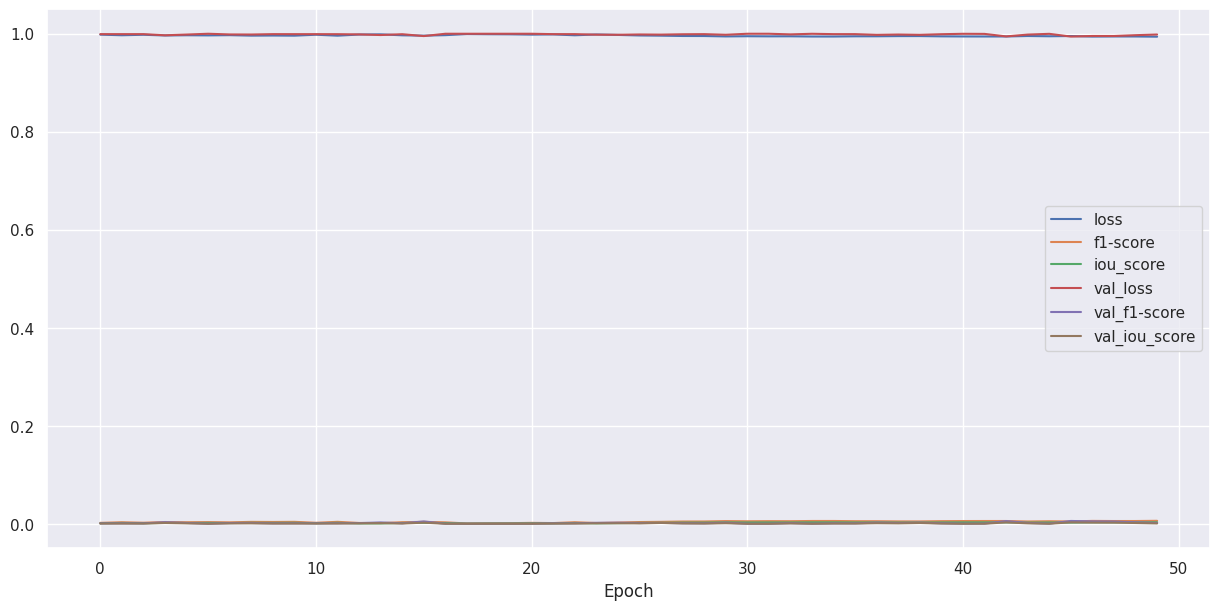

In [27]:
sns.set_theme()
pd.DataFrame(history1.history).plot(figsize=(15, 7))
plt.xlabel("Epoch")
plt.legend(loc="best")
plt.show()

In [40]:
test_images = create_test_dataset('/content/drive/MyDrive/Road_Anamoly_semantic_segmentation')

30/30 [==============================] - 21s 485ms/step


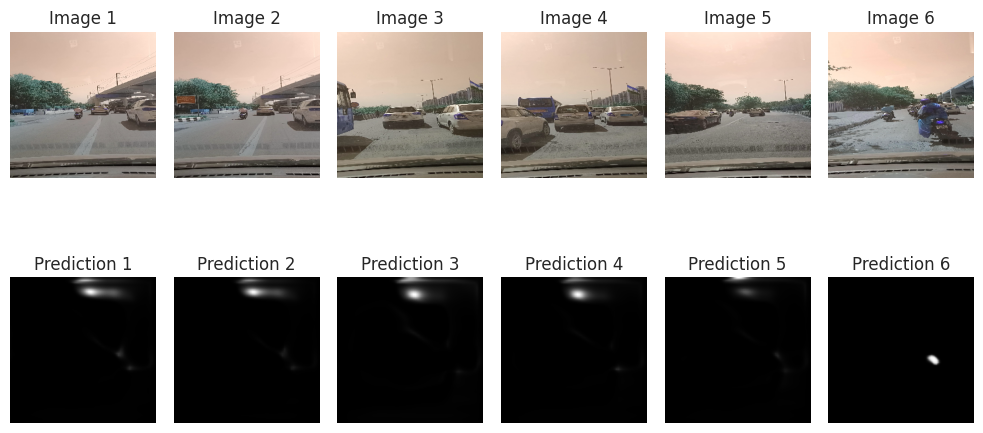

In [41]:
predict_and_plot(model1, "VGG19.h5", test_images, 6)